## Import

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import itertools
import matplotlib.pyplot as plt
import numpy as np

import subprocess
import os

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    '''
        Discriminator model
    '''
    def __init__(self, in_features, out_features):
        super().__init__()

        self.hidden_0 = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
        )
        self.hidden_1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4)
        )
        self.hidden_2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.out(x)
        return x

## Generator

In [ ]:
class Generator(nn.Module):
    '''
        Generator model
    '''
    def __init__(self, in_features, out_features):
        super().__init__()

        self.hidden_0 = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.hidden_1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.hidden_2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.out = nn.Sequential(
            nn.Linear(1024, out_features),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.out(x)
        return x

## Noise + Image Convert Helper

In [ ]:
def noise(data_size):
    '''
    Generates data_size number of random noise
    '''
    noise_features = 100
    n = torch.randn(data_size, noise_features)
    return n

def im_convert(tensor):
    '''
        Convert Tensor to displable format
    '''
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

## Loading training dataset

In [ ]:
# Loading training dataset

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])

dataset = datasets.FashionMNIST(root='dataset/', train=True,
                        transform=transforms, download=True)
dataloader = DataLoader(dataset, batch_size=128,
                        drop_last=True,
                        shuffle=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8086483.93it/s] 


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140266.04it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2645882.28it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5639142.59it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



## Load Models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create discriminator and generator
discriminator = Discriminator(in_features=784, out_features=1).to(device)
generator = Generator(in_features=100, out_features=784).to(device)

# Create 100 test_noise for visualizing how well our model perform.
test_noise = noise(100).to(device)

## Optimizer

In [ ]:
# Optimizers and loss
lr = 0.0002
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

## True and False Labels

In [ ]:
# True and False Labels.  128 is the batch size
true_label = torch.ones(128, 1).to(device)
false_label = torch.zeros(128, 1).to(device)

## Create folder to hold result

In [ ]:
# Create folder to hold result
result_folder = 'gan1-result'
if not os.path.exists(result_folder ):
    os.makedirs(result_folder )

## Training in action

In [ ]:
# Training in action
print("Starting Training...")

num_epochs = 35
discriminator_loss_history = []
generator_loss_history = []

for epoch in range(1, num_epochs+1):
    discriminator_batch_loss = 0.0
    generator_batch_loss = 0.0
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.shape[0]

        discriminator.zero_grad()

        # Train discriminator to get better at differentiate real/fake data
        # 1.1 Train discriminator on real data
        d_real_predict = discriminator(data.view(data.shape[0], -1))
        d_real_loss = criterion(d_real_predict, true_label)


        # 1.2 Train discriminator on fake data from generator
        d_fake_noise = noise(batch_size).to(device)
        # Generate outputs and detach to avoid training the Generator on these labels
        d_fake_input = generator(d_fake_noise).detach()
        d_fake_predict = discriminator(d_fake_input)
        d_fake_loss = criterion(d_fake_predict, false_label)

        # 1.3 combine real loss and fake loss for discriminator
        discriminator_loss = d_real_loss + d_fake_loss
        discriminator_batch_loss += discriminator_loss.item()
        discriminator_loss.backward()
        optimizerD.step()


        # Train generator to get better at deceiving discriminator
        g_fake_noise = noise(batch_size).to(device)
        g_fake_input = generator(g_fake_noise)
        generator.zero_grad()
        # Get prediction from discriminator
        g_fake_predict = discriminator(g_fake_input)
        generator_loss = criterion(g_fake_predict, true_label)
        generator_batch_loss += generator_loss.item()
        generator_loss.backward()
        optimizerG.step()

        # print loss every 100 batches
        if (batch_idx + 1) % 100 == 0:

            print(f'Epoch [{epoch}/{num_epochs}]  Batch {batch_idx + 1}/{len(dataloader)} \
                    Loss D: {discriminator_loss:.4f}, Loss G: {generator_loss:.4f}')


    discriminator_loss_history.append(discriminator_batch_loss / (batch_idx + 1))
    generator_loss_history.append(generator_batch_loss / (batch_idx + 1))

    with torch.no_grad():

        fake_images = generator(test_noise)

        size_figure_grid = 10
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

        for k in range(10*10):
            i = k // 10
            j = k % 10
            ax[i, j].cla()
            ax[i, j].imshow(im_convert(fake_images[k].view(1,28,28)))

        label = 'Epoch {0}'.format(epoch)
        fig.text(0.5, 0.04, label, ha='center')
        plt.savefig(result_folder + "/gan%03d.png" % epoch)
        plt.show(block=False)
        plt.pause(1.5)
        plt.close(fig)

## Create gif, 2 frames per second

In [ ]:
# create gif, 2 frames per second
subprocess.call([
    'ffmpeg', '-framerate', '2', '-i', \
    result_folder + '/gan%03d.png', result_folder+'/output.gif'
])

0

## Plot Loss History

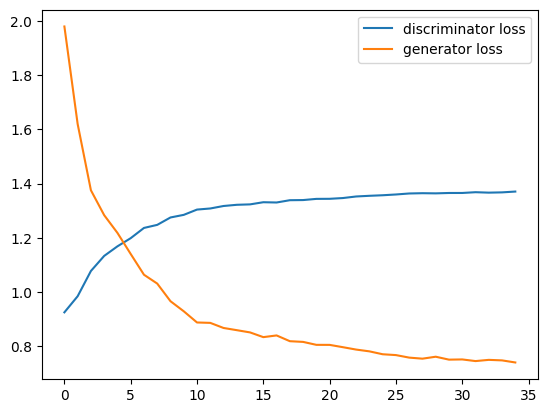

In [ ]:
plt.clf()
plt.plot(discriminator_loss_history, label='discriminator loss')
plt.plot(generator_loss_history, label='generator loss')
plt.savefig(result_folder + "/loss-history.png")
plt.legend()
plt.show()

In [ ]:
## Download Output From Google Colab to local
from google.colab import files
files.download(result_folder)